In [64]:
import geopandas as gpd
import torch
import numpy as np

city = 'Durham'
gdf = gpd.read_file(f'../data/shapefiles/{city}/pm_trav.shp')
gdf.columns

Index(['datetime', 'temp_f', 'hi_f', 'rh', 'file', 'kmph', 'trav_id',
       'geometry'],
      dtype='object')

In [56]:
gdf.total_bounds
gdf.crs

<Geographic 2D CRS: GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [65]:
# gdf = gdf.to_crs(epsg=3857)
bounds = gdf.total_bounds
bounds

array([-78.966885  ,  35.71172667, -78.51526   ,  36.05379667])

In [4]:
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
coordinates = gdf[['x', 'y']].to_numpy()
print(coordinates)

[[-8748477.25766592  4283361.21172331]
 [-8748471.32062641  4283369.22556502]
 [-8748464.64145696  4283377.69734695]
 ...
 [-8759026.44921095  4271549.72509116]
 [-8759019.7700415   4271544.46456151]
 [-8758995.46528601  4271527.31067813]]


In [31]:
X, y = coordinates, gdf.temp_f.to_numpy()

In [32]:
import numpy as np
random_indices = np.random.choice(len(X), size=5000, replace=False)
X = X[random_indices]
y = y[random_indices]
X.shape, y.shape

((5000, 2), (5000,))

In [33]:
# Now, we need to standardize the data for the final fit
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_train = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_train = (y - y_mean) / (y_std)

In [34]:
import torch
# Convert the arrays to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [123]:
import gpytorch
from gpytorch.kernels import Kernel, MaternKernel
import torch


class NonStationaryKernel(Kernel):
    """
    A non-stationary kernel that applies a parametric signal variance
    on top of a base stationary kernel, with multiple RBF widths.
    """
    def __init__(self, base_kernel=None, num_rbf_centers=10, input_dim=2):
        super(NonStationaryKernel, self).__init__()
        self.base_kernel = base_kernel

        # Initialize RBF centers constrained to [0, 1] via sigmoid
        # initial_centers = torch.tensor([[0.2,0.2],
        #                                [0.2,0.8],
        #                                [0.8,0.8],
        #                                [0.8,0.2]]
        #                                )
        # self.register_parameter(
        #     name="raw_rbf_centers",
        #     parameter=torch.nn.Parameter(initial_centers)
        # )

        # Define fixed RBF centers
        self.rbf_centers = torch.tensor(
            [[0.2, 0.2], [0.2, 0.8], [0.8, 0.8], [0.8, 0.2]],
            requires_grad=False,  # Make these non-trainable
        )


        # Define coefficients (c_k in g(x))
        self.register_parameter(
            name="coefficients",
            parameter=torch.nn.Parameter(torch.randn(num_rbf_centers))
        )

        # Initialize RBF widths constrained to (0, ∞) via softplus
        self.register_parameter(
            name="raw_rbf_widths",
            parameter=torch.nn.Parameter(torch.ones(num_rbf_centers))
        )

        # Register transforms for constraints
        # self.register_constraint("raw_rbf_centers", gpytorch.constraints.Interval(0.0, 1.0))
        self.register_constraint("raw_rbf_widths", gpytorch.constraints.Positive())

    # @property
    # def rbf_centers(self):
    #     # Apply sigmoid transformation to ensure centers are in [0, 1]
    #     return torch.sigmoid(self.raw_rbf_centers)

    @property
    def rbf_widths(self):
        # Apply softplus transformation to ensure widths are positive
        return torch.nn.functional.softplus(self.raw_rbf_widths)

    def forward(self, x1, x2, **params):
        # Compute g(x) for x1 and x2
        g_x1 = self._compute_signal_variance(x1)
        g_x2 = self._compute_signal_variance(x2)

        # Compute the base kernel k_stat(x1, x2)
        base_k = self.base_kernel(x1, x2, **params)

        # Return g(x1) * g(x2) * k_stat(x1, x2)
        return g_x1.unsqueeze(-1) * g_x2.unsqueeze(-2) * base_k

    def _compute_signal_variance(self, x):
        """
        Compute g(x) = sum(c_k * RBF(x_k, x)) with per-center RBF widths.
        """
        # Pairwise distances between x and RBF centers
        distances = torch.cdist(x, self.rbf_centers) ** 2

        # Compute RBF values with per-center widths
        rbf_values = torch.exp(-distances / self.rbf_widths.unsqueeze(0))

        # g(x) = sum(c_k * RBF(x_k, x))
        g_x = torch.matmul(rbf_values, self.coefficients)
        return g_x


# Example of using the kernel in a GP model
class NonStationaryGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(NonStationaryGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = NonStationaryKernel(
            base_kernel=MaternKernel(), num_rbf_centers=4, input_dim=train_x.shape[-1]
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Training the model
def train_model(train_x, train_y, likelihood):
    # Initialize the model and likelihood
    model = NonStationaryGPModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # Use marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    for i in range(50):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()

        # Print training progress
        print(f"Iter {i+1}/50 - Loss: {loss.item():.3f}")
        print(f"Base Kernel Lengthscale: {model.covar_module.base_kernel.lengthscale.item()}")
        print(f"RBF Centers: {model.covar_module.rbf_centers.detach().numpy()}")
        print(f"RBF Widths: {model.covar_module.raw_rbf_widths.detach().numpy()}")
        optimizer.step()

    return model


# Example usage
if __name__ == "__main__":

    # Initialize likelihood and train the model
    fixed_noise = torch.full_like(y_train, 0.05)
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=fixed_noise)
    trained_model = train_model(x_train, y_train, likelihood)


Iter 1/50 - Loss: 6.437
Base Kernel Lengthscale: 0.6931471824645996
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [1. 1. 1. 1.]
Iter 2/50 - Loss: 6.191
Base Kernel Lengthscale: 0.6443966627120972
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [1.1        0.9000001  1.0999999  0.90000004]
Iter 3/50 - Loss: 5.951
Base Kernel Lengthscale: 0.598182737827301
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [1.1993668 0.8001786 1.1999638 0.8016311]
Iter 4/50 - Loss: 5.724
Base Kernel Lengthscale: 0.5543236136436462
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [1.2971263 0.702295  1.2996572 0.7060554]
Iter 5/50 - Loss: 5.498
Base Kernel Lengthscale: 0.5127665400505066
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [1.3927282 0.6085416 1.3989809 0.6138619]
Iter 6/50 - Loss: 5.267
Base Kernel Lengthscale: 0.4734722673892975
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]

/opt/anaconda3/envs/research/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6808136701583862 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 22/50 - Loss: 1.699
Base Kernel Lengthscale: 0.10561738908290863
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [2.8767576  1.1725886  3.0849047  0.05719459]


/opt/anaconda3/envs/research/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2653518915176392 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 23/50 - Loss: 1.588
Base Kernel Lengthscale: 0.09603709727525711
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [2.9480622  1.2592666  3.169628   0.09615815]


/opt/anaconda3/envs/research/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.7255722284317017 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 24/50 - Loss: 1.544
Base Kernel Lengthscale: 0.08759831637144089
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [3.0148306  1.3423772  3.249382   0.13676223]
Iter 25/50 - Loss: 0.933
Base Kernel Lengthscale: 0.08017232269048691
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [3.077191  1.4218158 3.324213  0.1784713]
Iter 26/50 - Loss: 0.598
Base Kernel Lengthscale: 0.07346205413341522
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [3.136261  1.4997209 3.395818  0.2236314]
Iter 27/50 - Loss: 0.755
Base Kernel Lengthscale: 0.06770376861095428
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [3.1905763  1.5716728  3.4617453  0.26641348]
Iter 28/50 - Loss: 0.767
Base Kernel Lengthscale: 0.06272309273481369
RBF Centers: [[0.2 0.2]
 [0.2 0.8]
 [0.8 0.8]
 [0.8 0.2]]
RBF Widths: [3.2406     1.6379318  3.5226142  0.30814645]
Iter 29/50 - Loss: 0.831
Base Kernel Lengthscale: 0.05844515562057495
RBF Cent

In [126]:
import numpy as np

rbf_centers = np.array([[0.2, 0.2 ],
                        [0.2,  0.8],
                        [0.8,  0.8],
                        [0.8,  0.2]])

rbf_widths = np.array([2.549938, 0.80074596, 2.703254, -0.05053724])
rbf_widths = np.maximum(rbf_widths, 0)
base_kernel_lengthscale = 0.15786544978618622
rbf_widths *= base_kernel_lengthscale
coordinates = rbf_centers * x_scale+x_shift
length_scale = np.matmul(np.array([rbf_widths]).T, np.array([x_scale]))
print(length_scale)
# print(coordinates)

[[20224.85110456 18910.9771096 ]
 [ 6351.12218947  5938.53204281]
 [21440.87803225 20048.00685956]
 [    0.             0.        ]]


In [122]:
model

NameError: name 'model' is not defined

In [124]:
import pyproj

# Define the source and target coordinate reference systems
source_crs = pyproj.CRS.from_epsg(3857)
target_crs = pyproj.CRS.from_epsg(4326)

# Create a transformer object
transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

# Convert the coordinates
converted_coordinates = transformer.transform(coordinates[:, 0], coordinates[:, 1])

# Print the converted coordinates
print(converted_coordinates)

(array([35.78030404, 35.98545714, 35.98545714, 35.78030404]), array([-78.87638167, -78.87638167, -78.60558167, -78.60558167]))


In [94]:
import matplotlib.colors as colors
import matplotlib.colors as colors
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs

In [95]:
# Let's create a colormap with 15 colors, to match the 15 classes in the NLCD dataset.
custom_colors = [
    "royalblue",
    "mistyrose",
    "salmon",
    "red",
    "darkred",
    "tan",
    "lawngreen",
    "darkgreen",
    "yellowgreen",
    "goldenrod",
    "lemonchiffon",
    "yellow",
    "violet",
    "lightblue",
    "cyan"
]
cmap = colors.ListedColormap(custom_colors)

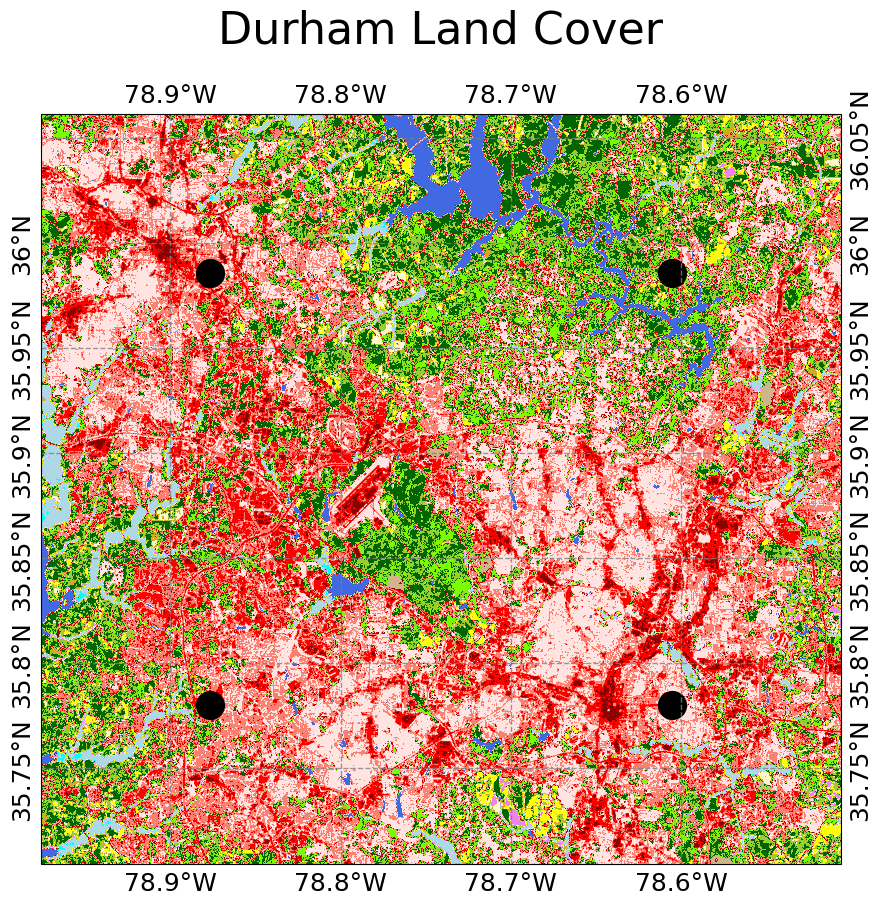

In [134]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import rasterio as rio

tif_nlcd = f'../data/land/{city}_nlcd.tif'
with rio.open(tif_nlcd) as src:
    nlcd = src.read(1)
    bounds = src.bounds


new_nlcd = nlcd.copy()
for i, j in enumerate(np.unique(nlcd)):
    new_nlcd[nlcd == j] = i

# Generate land cover colormap
fig = plt.figure(figsize=(10, 10))

# Plot the raster data
img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.8, linestyle='--', ylabel_style={'size': 18, 'rotation': 'vertical'}, xlabel_style={'size': 18})

img = plt.imshow(new_nlcd, extent=img_extent, cmap=cmap)

# Add scatter points for the coordinates
ax.scatter(converted_coordinates[1], converted_coordinates[0], color='black', s=400, transform=ccrs.PlateCarree(), label='Sample Points')

# Add legend for points
# ax.legend(loc='upper right', fontsize=12)

fig.suptitle(f'{city} Land Cover', fontsize=32)

# Save or display the plot
# plt.savefig(f'../figures/{city}_nlcd.png', dpi=300, bbox_inches='tight')
plt.show()